In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from subprocess import call
from tqdm import tqdm
import pystan
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

## Code for Fitting NBinomial Distribution using Bayesian MCMC sampling in PySTAN

In [2]:
rkfit_code = """
// Stan model for fitting negbinom2 to Data

data {
 int < lower = 1 > N; // Sample size
 int x[N]; // Data
 real p[4]; // Priors
}

parameters {
 real rt; // shape parameter
 real k; // rate parameter
}

transformed parameters {
}

model {
 rt ~ gamma((p[1]/p[2])^2,p[1]/p[2]^2);
 k ~ gamma((p[3]/p[4])^2,p[3]/p[4]^2);
 for(n in 1:N){
 
    x[n] ~  neg_binomial_2(rt, k);
 }
}
generated quantities {
 real sample;
 sample = neg_binomial_2_rng(rt,k);
} // The posterior predictive distribution 
"""
sm = pystan.StanModel(model_code=rkfit_code)

def fit_dist(cases,prior=np.array((2.5,2.0,0.45,0.1)),model=sm,warmup=500,iterations=5000,chains=8):
    data = {'N':len(cases),
            'x':cases,
            'p':prior}
    fit = sm.sampling(data = data, warmup = warmup, iter = iterations, chains = chains)
    return fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3f10350cb87bd05c02a052a97d286391 NOW.
D:\Anaconda3\envs\tensorflow\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\SAPTAR~1\AppData\Local\Temp\tmpu_suojli\stanfit4anon_model_3f10350cb87bd05c02a052a97d286391_6333541571448954567.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [3]:
df = pd.read_excel('ann2.xlsx',usecols=['children_all','dt_conf','cat_4','cluster_3'])

In [4]:
df.columns = ["children","cluster","date","category"]
df.date=pd.to_datetime(df.date,format='%d-%b-%Y')

### Till 31th May

#### Overall

In [5]:
fit = fit_dist(df[df.date<=pd.to_datetime('05-31-2020')]['children'].values,np.array([2.5,2.0,0.45,0.1]))

In [6]:
fit

Inference for Stan model: anon_model_3f10350cb87bd05c02a052a97d286391.
8 chains, each with iter=5000; warmup=500; thin=1; 
post-warmup draws per chain=4500, total post-warmup draws=36000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rt       0.32  2.3e-4   0.03   0.27    0.3   0.32   0.34   0.38  14043    1.0
k        0.05  2.2e-5 3.9e-3   0.04   0.05   0.05   0.05   0.06  32379    1.0
sample   0.32  7.8e-3   1.48    0.0    0.0    0.0    0.0    4.0  35949    1.0
lp__   -368.7  8.2e-3   1.01 -371.4 -369.1 -368.4 -368.0 -367.7  14963    1.0

Samples were drawn using NUTS at Thu Nov 19 22:38:36 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [7]:
pd.DataFrame(fit.summary()['summary'],columns=fit.summary()['summary_colnames'],index=fit.summary()['summary_rownames']).iloc[:2,:].to_csv('Outputs/rt_k_till31may.csv')

#### Histogram

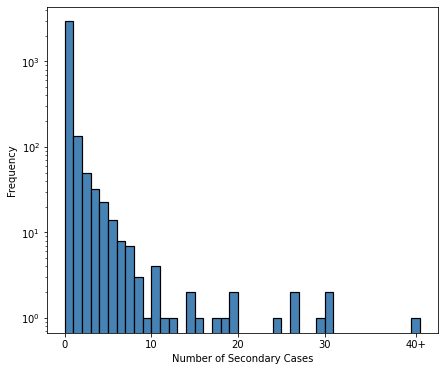

In [5]:
plt.figure(figsize=(7,6))
plt.hist(np.clip(df[df.date<=pd.to_datetime('05-31-2020')]['children'].values,0,40),bins=np.arange(0,42),zorder=-1,edgecolor='black',linewidth=1.2,color='steelblue')
plt.xlabel("Number of Secondary Cases")
plt.ylabel("Frequency")
plt.yscale('log')
plt.xticks([0,10,20,30,40.5],['0','10','20','30','40+'])
plt.savefig('Figures/Figures/Figures/child_hist_till31may.png',dpi=300)
plt.show()

#### Across Category

In [8]:
for i in np.unique(df['category']):
    print(i)
    vals = df[np.logical_and(df.date<=pd.to_datetime('05-31-2020'),df['category'] == i)]['children'].values
    print(vals.shape)
    fit = fit_dist(vals,np.array([2.5,2.0,0.45,0.1]))
    print(fit)
    pd.DataFrame(fit.summary()['summary'],columns=fit.summary()['summary_colnames'],index=fit.summary()['summary_rownames']).iloc[:2,:].to_csv(f'Outputs/rt_k_{i}_till31may.csv')

Imported Domestic
(1897,)


Inference for Stan model: anon_model_3f10350cb87bd05c02a052a97d286391.
8 chains, each with iter=5000; warmup=500; thin=1; 
post-warmup draws per chain=4500, total post-warmup draws=36000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rt        0.1  1.9e-4   0.02   0.07   0.09    0.1   0.11   0.14   9918    1.0
k        0.02  2.0e-5 3.3e-3   0.01   0.02   0.02   0.02   0.03  25392    1.0
sample    0.1  4.3e-3   0.83    0.0    0.0    0.0    0.0    1.0  36280    1.0
lp__   -140.6  9.5e-3   1.02 -143.3 -141.0 -140.2 -139.8 -139.6  11584    1.0

Samples were drawn using NUTS at Thu Nov 19 20:23:29 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Imported International
(118,)


Inference for Stan model: anon_model_3f10350cb87bd05c02a052a97d286391.
8 chains, each with iter=5000; warmup=500; thin=1; 
post-warmup draws per chain=4500, total post-warmup draws=36000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rt       0.25  5.5e-4   0.07   0.14    0.2   0.24   0.29    0.4  14420    1.0
k        0.33  5.9e-4   0.08   0.19   0.27   0.32   0.38   0.51  18120    1.0
sample   0.24  3.5e-3   0.67    0.0    0.0    0.0    0.0    2.0  35428    1.0
lp__   -85.49  9.6e-3   1.05  -88.3 -85.89 -85.17 -84.74 -84.47  11931    1.0

Samples were drawn using NUTS at Thu Nov 19 20:23:39 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Local Traced
(820,)
Inference for Stan model: anon_model_3f10350cb87bd05c02a052a97d286391.
8 chains, each with iter=5000; warmup=500; thin=1; 
post-warmup draws per chain=4500, total post-warmup dra

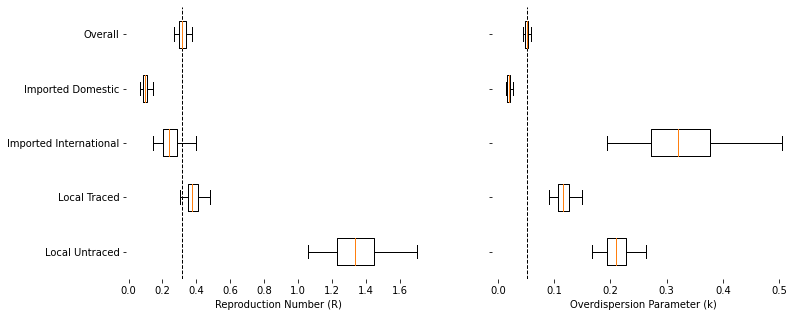

In [9]:
temp = pd.read_csv('Outputs/rt_k_till31may.csv')
rtm = temp["50%"][0]
km = temp["50%"][1]

rts=[{
    'label' : "Overall",
    'whislo': temp["2.5%"][0],    # Bottom whisker position
    'q1'    : temp["25%"][0],    # First quartile (25th percentile)
    'med'   : temp["50%"][0],    # Median         (50th percentile)
    'q3'    : temp["75%"][0],    # Third quartile (75th percentile)
    'whishi': temp["97.5%"][0],    # Top whisker position
    'fliers': []        # Outliers
    }]
ks = [{
    'label' : "Overall",
    'whislo': temp["2.5%"][1],    # Bottom whisker position
    'q1'    : temp["25%"][1],    # First quartile (25th percentile)
    'med'   : temp["50%"][1],    # Median         (50th percentile)
    'q3'    : temp["75%"][1],    # Third quartile (75th percentile)
    'whishi': temp["97.5%"][1],    # Top whisker position
    'fliers': []        # Outliers
    }]
for i in np.unique(df['category']):
    temp = pd.read_csv(f'Outputs/rt_k_{i}_till31may.csv')
    rts.append({
    'label' : i,
    'whislo': temp["2.5%"][0],    # Bottom whisker position
    'q1'    : temp["25%"][0],    # First quartile (25th percentile)
    'med'   : temp["50%"][0],    # Median         (50th percentile)
    'q3'    : temp["75%"][0],    # Third quartile (75th percentile)
    'whishi': temp["97.5%"][0],    # Top whisker position
    'fliers': []        # Outliers
    })
    ks.append({
    'label' : i,
    'whislo': temp["2.5%"][1],    # Bottom whisker position
    'q1'    : temp["25%"][1],    # First quartile (25th percentile)
    'med'   : temp["50%"][1],    # Median         (50th percentile)
    'q3'    : temp["75%"][1],    # Third quartile (75th percentile)
    'whishi': temp["97.5%"][1],    # Top whisker position
    'fliers': []        # Outliers
    })
rts.reverse()
ks.reverse()

fig, ax = plt.subplots(1,2,figsize=(12,5))

ax[0].bxp(rts, showfliers=False,vert=False)
ax[0].set_xlabel("Reproduction Number (R)")
ax[0].set_frame_on(False)
ax[0].vlines(rtm,0.5,5.5,color='k',linestyle='dashed',linewidth=1)
ax[1].bxp(ks, showfliers=False,vert=False)
ax[1].set_xlabel("Overdispersion Parameter (k)")
ax[1].set_yticklabels(["","","","",""])
ax[1].set_frame_on(False)
ax[1].vlines(km,0.5,5.5,color='k',linestyle='dashed',linewidth=1)
plt.savefig("Figures/rt_k_till31may.png",dpi=300)

### Till 13th June

#### Overall

In [10]:
fit = fit_dist(df[df.date<=pd.to_datetime('06-13-2020')]['children'].values,np.array([2.5,2.0,0.45,0.1]))

In [11]:
fit

Inference for Stan model: anon_model_3f10350cb87bd05c02a052a97d286391.
8 chains, each with iter=5000; warmup=500; thin=1; 
post-warmup draws per chain=4500, total post-warmup draws=36000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rt       0.23  1.5e-4   0.02    0.2   0.22   0.23   0.24   0.26  10194    1.0
k        0.04  1.3e-5 2.4e-3   0.04   0.04   0.04   0.04   0.04  37639    1.0
sample   0.24  7.1e-3   1.35    0.0    0.0    0.0    0.0    3.0  35786    1.0
lp__   -889.1  8.7e-3   1.01 -891.8 -889.5 -888.8 -888.4 -888.1  13415    1.0

Samples were drawn using NUTS at Thu Nov 19 20:32:01 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [12]:
pd.DataFrame(fit.summary()['summary'],columns=fit.summary()['summary_colnames'],index=fit.summary()['summary_rownames']).iloc[:2,:].to_csv('Outputs/rt_k_till13june.csv')

#### Histogram

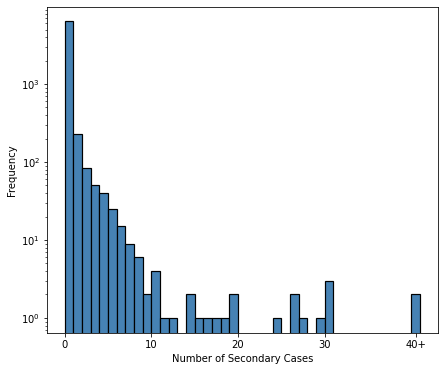

In [6]:
plt.figure(figsize=(7,6))
plt.hist(np.clip(df[df.date<=pd.to_datetime('06-13-2020')]['children'].values,0,40),bins=np.arange(0,42),zorder=-1,edgecolor='black',linewidth=1.2,color='steelblue')
plt.xlabel("Number of Secondary Cases")
plt.ylabel("Frequency")
plt.yscale('log')
plt.xticks([0,10,20,30,40.5],['0','10','20','30','40+'])
plt.savefig('Figures/Figures/Figures/child_hist_till13june.png',dpi=300)
plt.show()

#### Across Category

In [13]:
for i in np.unique(df['category']):
    print(i)
    vals = df[np.logical_and(df.date<=pd.to_datetime('06-13-2020'),df['category'] == i)]['children'].values
    print(vals.shape)
    fit = fit_dist(vals,np.array([2.5,2.0,0.45,0.1]))
    print(fit)
    pd.DataFrame(fit.summary()['summary'],columns=fit.summary()['summary_colnames'],index=fit.summary()['summary_rownames']).iloc[:2,:].to_csv(f'Outputs/rt_k_{i}_till13june.csv')

Imported Domestic
(4643,)
Inference for Stan model: anon_model_3f10350cb87bd05c02a052a97d286391.
8 chains, each with iter=5000; warmup=500; thin=1; 
post-warmup draws per chain=4500, total post-warmup draws=36000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rt       0.06  8.0e-5 7.8e-3   0.04   0.05   0.06   0.06   0.07   9568    1.0
k        0.02  1.3e-5 2.2e-3   0.01   0.01   0.02   0.02   0.02  28371    1.0
sample   0.05  2.8e-3   0.52    0.0    0.0    0.0    0.0    0.0  35237    1.0
lp__   -404.5  9.6e-3   1.04 -407.3 -404.9 -404.2 -403.8 -403.5  11739    1.0

Samples were drawn using NUTS at Thu Nov 19 20:34:51 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Imported International
(208,)


Inference for Stan model: anon_model_3f10350cb87bd05c02a052a97d286391.
8 chains, each with iter=5000; warmup=500; thin=1; 
post-warmup draws per chain=4500, total post-warmup draws=36000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rt       0.14  2.6e-4   0.03   0.09   0.12   0.14   0.16   0.22  16239    1.0
k        0.29  5.4e-4   0.08   0.17   0.24   0.29   0.34   0.46  19641    1.0
sample   0.14  2.5e-3   0.47    0.0    0.0    0.0    0.0    1.0  35549    1.0
lp__   -99.79  9.0e-3   1.03 -102.5 -100.1 -99.47 -99.06 -98.79  13096    1.0

Samples were drawn using NUTS at Thu Nov 19 20:35:05 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Local Traced
(1219,)
Inference for Stan model: anon_model_3f10350cb87bd05c02a052a97d286391.
8 chains, each with iter=5000; warmup=500; thin=1; 
post-warmup draws per chain=4500, total post-warmup dr

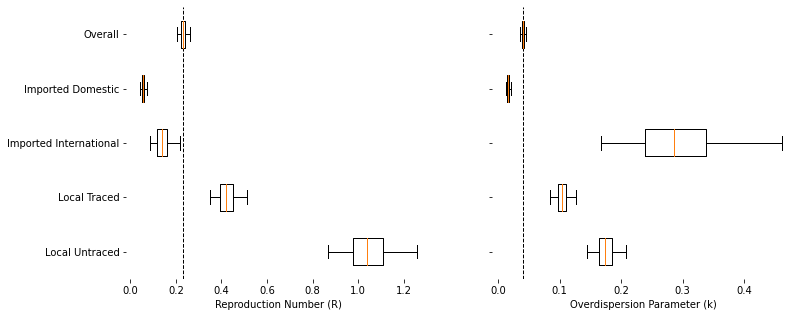

In [14]:
temp = pd.read_csv('Outputs/rt_k_till13june.csv')
rtm = temp["50%"][0]
km = temp["50%"][1]

rts=[{
    'label' : "Overall",
    'whislo': temp["2.5%"][0],    # Bottom whisker position
    'q1'    : temp["25%"][0],    # First quartile (25th percentile)
    'med'   : temp["50%"][0],    # Median         (50th percentile)
    'q3'    : temp["75%"][0],    # Third quartile (75th percentile)
    'whishi': temp["97.5%"][0],    # Top whisker position
    'fliers': []        # Outliers
    }]
ks = [{
    'label' : "Overall",
    'whislo': temp["2.5%"][1],    # Bottom whisker position
    'q1'    : temp["25%"][1],    # First quartile (25th percentile)
    'med'   : temp["50%"][1],    # Median         (50th percentile)
    'q3'    : temp["75%"][1],    # Third quartile (75th percentile)
    'whishi': temp["97.5%"][1],    # Top whisker position
    'fliers': []        # Outliers
    }]
for i in np.unique(df['category']):
    temp = pd.read_csv(f'Outputs/rt_k_{i}_till13june.csv')
    rts.append({
    'label' : i,
    'whislo': temp["2.5%"][0],    # Bottom whisker position
    'q1'    : temp["25%"][0],    # First quartile (25th percentile)
    'med'   : temp["50%"][0],    # Median         (50th percentile)
    'q3'    : temp["75%"][0],    # Third quartile (75th percentile)
    'whishi': temp["97.5%"][0],    # Top whisker position
    'fliers': []        # Outliers
    })
    ks.append({
    'label' : i,
    'whislo': temp["2.5%"][1],    # Bottom whisker position
    'q1'    : temp["25%"][1],    # First quartile (25th percentile)
    'med'   : temp["50%"][1],    # Median         (50th percentile)
    'q3'    : temp["75%"][1],    # Third quartile (75th percentile)
    'whishi': temp["97.5%"][1],    # Top whisker position
    'fliers': []        # Outliers
    })
rts.reverse()
ks.reverse()

fig, ax = plt.subplots(1,2,figsize=(12,5))

ax[0].bxp(rts, showfliers=False,vert=False)
ax[0].set_xlabel("Reproduction Number (R)")
ax[0].set_frame_on(False)
ax[0].vlines(rtm,0.5,5.5,color='k',linestyle='dashed',linewidth=1)
ax[1].bxp(ks, showfliers=False,vert=False)
ax[1].set_xlabel("Overdispersion Parameter (k)")
ax[1].set_yticklabels(["","","","",""])
ax[1].set_frame_on(False)
ax[1].vlines(km,0.5,5.5,color='k',linestyle='dashed',linewidth=1)
plt.savefig("Figures/rt_k_till13june.png",dpi=300)

### Till 7th July

#### Overall

In [15]:
fit = fit_dist(df[df.date<=pd.to_datetime('07-07-2020')]['children'].values,np.array([2.5,2.0,0.45,0.1]))

In [16]:
fit

Inference for Stan model: anon_model_3f10350cb87bd05c02a052a97d286391.
8 chains, each with iter=5000; warmup=500; thin=1; 
post-warmup draws per chain=4500, total post-warmup draws=36000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rt       0.19  7.0e-5 6.7e-3   0.18   0.18   0.19   0.19    0.2   9165    1.0
k        0.04  6.1e-6 1.2e-3   0.03   0.03   0.04   0.04   0.04  37840    1.0
sample   0.19  5.9e-3   1.12    0.0    0.0    0.0    0.0    2.0  36251    1.0
lp__    -4284  9.6e-3    1.0  -4286  -4284  -4283  -4283  -4283  10820    1.0

Samples were drawn using NUTS at Thu Nov 19 20:57:22 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [17]:
pd.DataFrame(fit.summary()['summary'],columns=fit.summary()['summary_colnames'],index=fit.summary()['summary_rownames']).iloc[:2,:].to_csv('Outputs/rt_k_till7july.csv')

#### Histogram

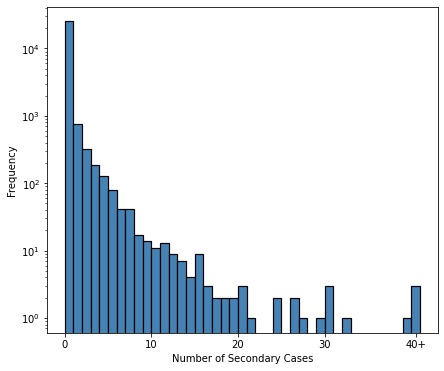

In [30]:
plt.figure(figsize=(7,6))
plt.hist(np.clip(df[df.date<=pd.to_datetime('07-07-2020')]['children'].values,0,40),bins=np.arange(0,42),zorder=-1,edgecolor='black',linewidth=1.2,color='steelblue')
plt.xlabel("Number of Secondary Cases")
plt.ylabel("Frequency")
plt.yscale('log')
plt.xticks([0,10,20,30,40.5],['0','10','20','30','40+'])
plt.savefig('Figures/Figures/Figures/child_hist_till07july.png',dpi=300)
plt.show()

#### Across Category

In [18]:
for i in np.unique(df['category']):
    print(i)
    vals = df[np.logical_and(df.date<=pd.to_datetime('07-07-2020'),df['category'] == i)]['children'].values
    print(vals.shape)
    fit = fit_dist(vals,np.array([2.5,2.0,0.45,0.1]))
    print(fit)
    pd.DataFrame(fit.summary()['summary'],columns=fit.summary()['summary_colnames'],index=fit.summary()['summary_rownames']).iloc[:2,:].to_csv(f'Outputs/rt_k_{i}_till7july.csv')

Imported Domestic
(6093,)
Inference for Stan model: anon_model_3f10350cb87bd05c02a052a97d286391.
8 chains, each with iter=5000; warmup=500; thin=1; 
post-warmup draws per chain=4500, total post-warmup draws=36000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rt       0.07  7.4e-5 7.3e-3   0.06   0.06   0.07   0.07   0.08   9870    1.0
k        0.02  1.2e-5 2.2e-3   0.02   0.02   0.02   0.02   0.02  34274    1.0
sample   0.07  3.1e-3   0.58    0.0    0.0    0.0    0.0    1.0  34447    1.0
lp__   -645.2  9.3e-3   1.03 -648.0 -645.6 -644.9 -644.5 -644.2  12190    1.0

Samples were drawn using NUTS at Thu Nov 19 21:00:43 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Imported International
(524,)


Inference for Stan model: anon_model_3f10350cb87bd05c02a052a97d286391.
8 chains, each with iter=5000; warmup=500; thin=1; 
post-warmup draws per chain=4500, total post-warmup draws=36000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rt       0.06  8.5e-5   0.01   0.04   0.05   0.06   0.07   0.09  21698    1.0
k        0.26  5.7e-4   0.07   0.14    0.2   0.25    0.3   0.42  16022    1.0
sample   0.07  1.5e-3   0.29    0.0    0.0    0.0    0.0    1.0  36580    1.0
lp__   -134.1  8.8e-3   1.01 -136.8 -134.5 -133.8 -133.3 -133.1  13273    1.0

Samples were drawn using NUTS at Thu Nov 19 21:01:04 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Local Traced
(4198,)
Inference for Stan model: anon_model_3f10350cb87bd05c02a052a97d286391.
8 chains, each with iter=5000; warmup=500; thin=1; 
post-warmup draws per chain=4500, total post-warmup dr

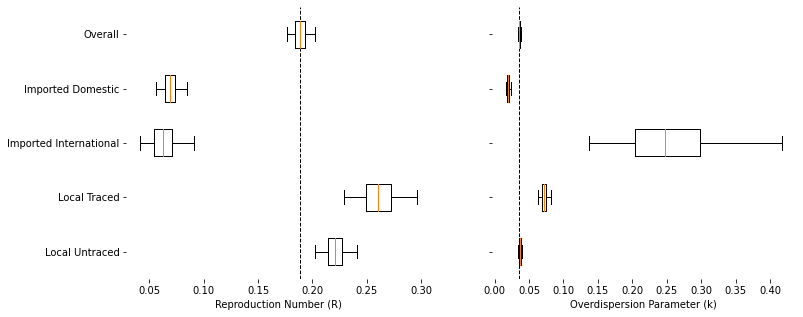

In [19]:
temp = pd.read_csv('Outputs/rt_k_till7july.csv')
rtm = temp["50%"][0]
km = temp["50%"][1]

rts=[{
    'label' : "Overall",
    'whislo': temp["2.5%"][0],    # Bottom whisker position
    'q1'    : temp["25%"][0],    # First quartile (25th percentile)
    'med'   : temp["50%"][0],    # Median         (50th percentile)
    'q3'    : temp["75%"][0],    # Third quartile (75th percentile)
    'whishi': temp["97.5%"][0],    # Top whisker position
    'fliers': []        # Outliers
    }]
ks = [{
    'label' : "Overall",
    'whislo': temp["2.5%"][1],    # Bottom whisker position
    'q1'    : temp["25%"][1],    # First quartile (25th percentile)
    'med'   : temp["50%"][1],    # Median         (50th percentile)
    'q3'    : temp["75%"][1],    # Third quartile (75th percentile)
    'whishi': temp["97.5%"][1],    # Top whisker position
    'fliers': []        # Outliers
    }]
for i in np.unique(df['category']):
    temp = pd.read_csv(f'Outputs/rt_k_{i}_till7july.csv')
    rts.append({
    'label' : i,
    'whislo': temp["2.5%"][0],    # Bottom whisker position
    'q1'    : temp["25%"][0],    # First quartile (25th percentile)
    'med'   : temp["50%"][0],    # Median         (50th percentile)
    'q3'    : temp["75%"][0],    # Third quartile (75th percentile)
    'whishi': temp["97.5%"][0],    # Top whisker position
    'fliers': []        # Outliers
    })
    ks.append({
    'label' : i,
    'whislo': temp["2.5%"][1],    # Bottom whisker position
    'q1'    : temp["25%"][1],    # First quartile (25th percentile)
    'med'   : temp["50%"][1],    # Median         (50th percentile)
    'q3'    : temp["75%"][1],    # Third quartile (75th percentile)
    'whishi': temp["97.5%"][1],    # Top whisker position
    'fliers': []        # Outliers
    })
rts.reverse()
ks.reverse()

fig, ax = plt.subplots(1,2,figsize=(12,5))

ax[0].bxp(rts, showfliers=False,vert=False)
ax[0].set_xlabel("Reproduction Number (R)")
ax[0].set_frame_on(False)
ax[0].vlines(rtm,0.5,5.5,color='k',linestyle='dashed',linewidth=1)
ax[1].bxp(ks, showfliers=False,vert=False)
ax[1].set_xlabel("Overdispersion Parameter (k)")
ax[1].set_yticklabels(["","","","",""])
ax[1].set_frame_on(False)
ax[1].vlines(km,0.5,5.5,color='k',linestyle='dashed',linewidth=1)
plt.savefig("Figures/rt_k_till7july.png",dpi=300)

### Generate Summary Table

In [41]:
data = [["","Till 31st May","Till 31st May","Till 13th June","Till 13th June","Till 7th July","Till 7th July"],
        ["","Reproductive Number (R)","Overdispersion parameter (k)","Reproductive Number (R)","Overdispersion parameter (k)","Reproductive Number (R)","Overdispersion parameter (k)"],
        ["All Cases","","","","","",""],
        ["Imported Domestic","","","","","",""],
        ["Imported International","","","","","",""],
        ["Local Traced","","","","","",""],
        ["Local Untraced","","","","","",""]]
for n,i in enumerate(["rt_k_till31may.csv","rt_k_till13june.csv","rt_k_till7july.csv"]):
    temp = pd.read_csv(i)
    data[2][1+2*n] = f'{temp["50%"][0]:0.2f} ({temp["2.5%"][0]:0.2f},{temp["97.5%"][0]:0.2f})'
    data[2][2+2*n] = f'{temp["50%"][1]:0.2f} ({temp["2.5%"][1]:0.2f},{temp["97.5%"][1]:0.2f})'

for m,h in enumerate(np.unique(df['category'])):
    for n,i in enumerate([f"rt_k_{h}_till31may.csv",f"rt_k_{h}_till13june.csv",f"rt_k_{h}_till7july.csv"]):
        temp = pd.read_csv(i)
        data[3+m][1+2*n] = f'{temp["50%"][0]:0.2f} ({temp["2.5%"][0]:0.2f},{temp["97.5%"][0]:0.2f})'
        data[3+m][2+2*n] = f'{temp["50%"][1]:0.2f} ({temp["2.5%"][1]:0.2f},{temp["97.5%"][1]:0.2f})'

pd.DataFrame(np.array(data)).to_csv('Outputs/rt_k_table.csv',index=False,header=False)

## Across Clusters

In [17]:
temp = df.dropna()
for i in np.unique(temp['cluster']):
    print(i)
    vals = temp[np.logical_and(temp.date<=pd.to_datetime('07-07-2020'),temp['cluster'] == i)]['children'].values
    print(vals.shape)
    if vals.shape[0]>0:
        fit = fit_dist(vals,np.array([2.5,2.0,0.45,0.1]))
        print(fit)
        pd.DataFrame(fit.summary()['summary'],columns=fit.summary()['summary_colnames'],index=fit.summary()['summary_rownames']).iloc[:2,:].to_csv(f'Outputs/rt_k_{i}_till13june.csv')

bellary
(221,)
Inference for Stan model: anon_model_3f10350cb87bd05c02a052a97d286391.
8 chains, each with iter=5000; warmup=500; thin=1; 
post-warmup draws per chain=4500, total post-warmup draws=36000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rt       1.04  1.2e-3   0.16   0.76   0.92   1.02   1.14    1.4  19539    1.0
k        0.23  2.3e-4   0.03   0.17   0.21   0.23   0.25   0.31  21968    1.0
sample   1.05    0.01   2.43    0.0    0.0    0.0    1.0    8.0  35374    1.0
lp__    14.51  8.5e-3   1.02  11.75  14.13  14.82  15.23   15.5  14355    1.0

Samples were drawn using NUTS at Thu Nov 19 23:07:18 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
pharma
(76,)
Inference for Stan model: anon_model_3f10350cb87bd05c02a052a97d286391.
8 chains, each with iter=5000; warmup=500; thin=1; 
post-warmup draws per chain=4500, total post-wa

#### Histogram

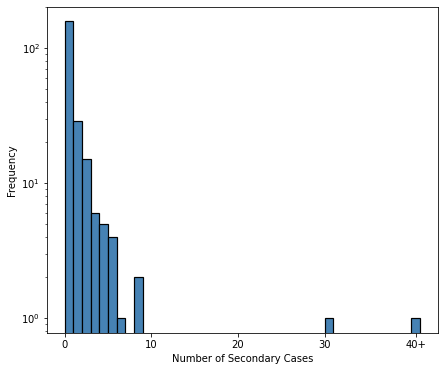

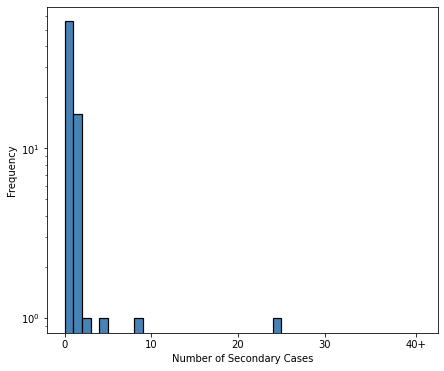

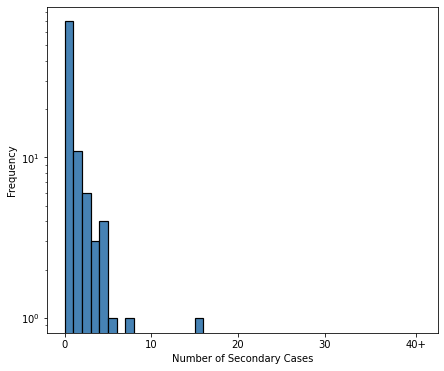

In [13]:
for i in np.unique(temp['cluster']):
    plt.figure(figsize=(7,6))
    plt.hist(np.clip(temp[temp['cluster']==i]['children'].values,0,40),bins=np.arange(0,42),zorder=-1,edgecolor='black',linewidth=1.2,color='steelblue')
    plt.xlabel("Number of Secondary Cases")
    plt.ylabel("Frequency")
    plt.yscale('log')
    plt.xticks([0,10,20,30,40.5],['0','10','20','30','40+'])
    plt.savefig(f'Figures/Figures/Figures/child_hist_{i}.png',dpi=300)
    plt.show()

## All Clusters

In [12]:
temp = df.dropna()

In [9]:
fit = fit_dist(temp['children'].values,np.array([2.5,2.0,0.45,0.1]))

In [10]:
fit

Inference for Stan model: anon_model_3f10350cb87bd05c02a052a97d286391.
8 chains, each with iter=5000; warmup=500; thin=1; 
post-warmup draws per chain=4500, total post-warmup draws=36000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rt       0.91  7.7e-4   0.11   0.72   0.83    0.9   0.98   1.15  20615    1.0
k        0.22  1.7e-4   0.03   0.17    0.2   0.21   0.23   0.27  25350    1.0
sample   0.92    0.01   2.21    0.0    0.0    0.0    1.0    7.0  35774    1.0
lp__   -33.74  8.3e-3    1.0 -36.43 -34.12 -33.43 -33.03 -32.76  14513    1.0

Samples were drawn using NUTS at Mon Nov 23 10:48:49 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [11]:
pd.DataFrame(fit.summary()['summary'],columns=fit.summary()['summary_colnames'],index=fit.summary()['summary_rownames']).iloc[:2,:].to_csv('Outputs/rt_k_allclusters.csv')

#### Histogram

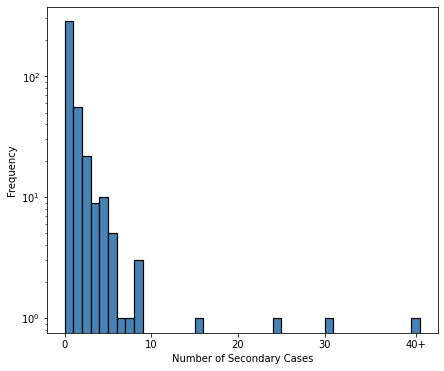

In [21]:
plt.figure(figsize=(7,6))
plt.hist(np.clip(temp['children'].values,0,40),bins=np.arange(0,42),zorder=-1,edgecolor='black',linewidth=1.2,color='steelblue')
plt.xlabel("Number of Secondary Cases")
plt.ylabel("Frequency")
plt.yscale('log')
plt.xticks([0,10,20,30,40.5],['0','10','20','30','40+'])
plt.savefig(f'Figures/Figures/Figures/child_hist_allclusters.png',dpi=300)
plt.show()

## Only confirmed

In [31]:
df = pd.read_excel('onlyconfirmedtraced956.xlsx')

In [23]:
fit = fit_dist(df['children_all'].values,np.array([2.5,2.0,0.45,0.1]))

In [24]:
fit

Inference for Stan model: anon_model_3f10350cb87bd05c02a052a97d286391.
8 chains, each with iter=5000; warmup=500; thin=1; 
post-warmup draws per chain=4500, total post-warmup draws=36000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rt       0.75  5.0e-4   0.08   0.62    0.7   0.75    0.8   0.91  22576    1.0
k        0.13  7.4e-5   0.01   0.11   0.12   0.13   0.14   0.15  26732    1.0
sample   0.74    0.01   2.29    0.0    0.0    0.0    0.0    7.0  36371    1.0
lp__   -20.65  8.5e-3   1.03 -23.42 -21.05 -20.34 -19.92 -19.65  14719    1.0

Samples were drawn using NUTS at Thu Nov 19 23:14:26 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [25]:
pd.DataFrame(fit.summary()['summary'],columns=fit.summary()['summary_colnames'],index=fit.summary()['summary_rownames']).iloc[:2,:].to_csv('Outputs/rt_k_confirmed.csv')

#### Histogram

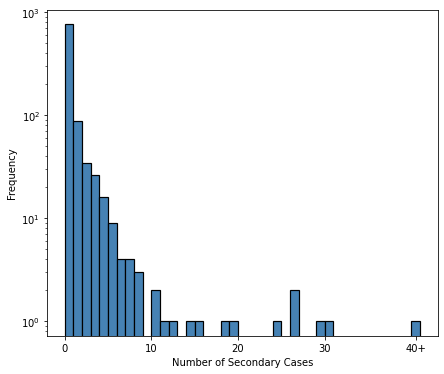

In [32]:
plt.figure(figsize=(7,6))
plt.hist(np.clip(df['children_all'].values,0,40),bins=np.arange(0,42),zorder=-1,edgecolor='black',linewidth=1.2,color='steelblue')
plt.xlabel("Number of Secondary Cases")
plt.ylabel("Frequency")
plt.yscale('log')
plt.xticks([0,10,20,30,40.5],['0','10','20','30','40+'])
plt.savefig('Figures/Figures/Figures/child_hist_confirmed.png',dpi=300)
plt.show()